This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
 

In [26]:
figname = '../paper/fig_result'

In [27]:
%run 0_parameters.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

This notebook introduces the problem addressed in this paper:

 - localizating an object in a large image
 - foveation
 - action (saccade)
       
      
2019-03-14
{'w': 28, 'minibatch_size': 100, 'train_batch_size': 100, 'test_batch_size': 1000, 'noise_batch_size': 1000, 'mean': 0.1307, 'std': 0.3081, 'N_pic': 128, 'offset_std': 30, 'offset_max': 35, 'noise': 1.0, 'contrast': 0.8, 'sf_0': 0.2, 'B_sf': 0.3, 'N_theta': 6, 'N_azimuth': 16, 'N_eccentricity': 10, 'N_phase': 2, 'N_X': 128, 'N_Y': 128, 'rho': 1.41, 'bias_deconv': True, 'p_dropout': 0.5, 'dim1': 1000, 'dim2': 1000, 'loss_func': BCEWithLogitsLoss(), 'lr': 0.01, 'do_adam': True, 'epochs': 80, 'bn1_bn_momentum': 0.5, 'bn2_bn_momentum': 0.5, 'momentum': 0.1, 'n_epochs': 10, 'num_processes': 1, 'no_cuda': True, 'log_interval': 100, 'verbose': 1, 'filename': '../data/2019-03-14', 'seed': 2019}
Overwriting train.py
The watermark extension is al

In [28]:
from what import WhatNet
model_path = "../data/MNIST_cnn.pt"
What_model = torch.load(model_path)

# Network

In [29]:
from retina import Display
d = Display(args)

from retina import Retina
r = Retina(args)

from where import Where
where = Where(args, d, r)

filename_train = args.filename + '_train3.pt'
%ls -lh {filename_train}
#%rm {filename_train}

Loading accuracy... min, max= 0.0145 0.9852
-rw-r--r--  1 laurentperrinet  staff    12M Mar 14 14:54 ../data/2019-03-14_train3.pt


In [30]:
%prun?

Docstring:
Run a statement through the python code profiler.

Usage, in line mode:
  %prun [options] statement

Usage, in cell mode:
  %%prun [options] [statement]
  code...
  code...

In cell mode, the additional code lines are appended to the (possibly
empty) statement in the first line.  Cell mode allows you to easily
profile multiline blocks without having to put them in a separate
function.

The given statement (which doesn't require quote marks) is run via the
python profiler in a manner similar to the profile.run() function.
Namespaces are internally managed to work correctly; profile.run
cannot be used in IPython because it makes certain assumptions about
namespaces which do not hold under IPython.

Options:

-l <limit>
  you can place restrictions on what or how much of the
  profile gets printed. The limit value can be:

     * A string: only information for function names containing this string
       is printed.

     * An integer: only these many lines are printed.

     *

In [31]:
%prun  -l 50 -s cumulative where.train(filename_train)

Loading file ../data/2019-03-14_train3.pt
 

         11571 function calls in 0.016 seconds

   Ordered by: cumulative time
   List reduced from 144 to 50 due to restriction <50>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.016    0.016 {built-in method builtins.exec}
        1    0.000    0.000    0.016    0.016 <string>:1(<module>)
        1    0.000    0.000    0.016    0.016 where.py:138(train)
        1    0.000    0.000    0.016    0.016 serialization.py:301(load)
        1    0.000    0.000    0.016    0.016 serialization.py:374(_load)
        1    0.000    0.000    0.009    0.009 {method 'load' of '_pickle.Unpickler' objects}
       20    0.000    0.000    0.007    0.000 serialization.py:491(persistent_load)
        4    0.000    0.000    0.007    0.002 serialization.py:396(_check_container_source)
        4    0.000    0.000    0.007    0.002 inspect.py:967(getsource)
        4    0.000    0.000    0.007    0.002 inspect.py:946(getsourcelines)
        4    0.00

#### Training

In [32]:
def test(net, optimizer=where.optimizer,
         vsize=args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase,
         asize=args.N_azimuth*args.N_eccentricity):
    
    data, label = next(iter(d.loader_test))
    batch_size = label.shape[0]

    retina_data = np.zeros((batch_size, args.N_phase * args.N_theta * args.N_azimuth * args.N_eccentricity))
    fixmap_data = np.zeros((batch_size, args.N_azimuth * args.N_eccentricity))

    for i in range(batch_size):
            data_fullfield, i_offset, j_offset = d.draw(data[i, 0, :, :].numpy())
            retina_data[i, :]  =  r.retina(data_fullfield)
            accuracy_colliculus[i,:], _ = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            
    retina_data = Variable(torch.FloatTensor(retina_data))
    accuracy_colliculus = Variable(torch.FloatTensor(accuracy_colliculus))
    
    with torch.no_grad():
        output = net(retina_data)
        acc, _ = accuracy_gain(output, accuracy_colliculus, batch_size)

    return acc


## Anywhere target, with noise

# Visualisation of some examples

In [33]:
data, label = next(iter(d.loader_test))
full, retina_data, accuracy_colliculus = where.minibatch(data)

In [34]:
data.shape, retina_data.shape, accuracy_colliculus.shape

(torch.Size([1000, 1, 28, 28]),
 torch.Size([1000, 1920]),
 torch.Size([1000, 160]))

In [35]:
retina_data


tensor([[ 0.1217, -0.0023, -0.0219,  ...,  0.0089,  0.4763, -0.7841],
        [-0.1416,  0.0969,  0.1116,  ...,  0.1477,  0.7284, -1.1642],
        [ 0.0152, -0.0345, -0.0768,  ...,  0.1895,  0.5974, -1.1601],
        ...,
        [ 0.0509,  0.0767,  0.0436,  ...,  0.0692,  0.7742, -0.9880],
        [-0.0966,  0.0581,  0.0065,  ..., -0.3457,  0.3483, -1.2613],
        [-0.1548, -0.1665, -0.1482,  ...,  0.3927,  0.8131, -1.4811]])

In [36]:
where.model.eval()

WhereNet(
  (bn1): Linear(in_features=1920, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=160, bias=True)
)

In [37]:
where.model(retina_data)


tensor([[-2.7237, -2.7063, -2.4574,  ..., -2.0585, -2.1835, -2.2087],
        [ 0.4935, -0.2005, -0.9620,  ..., -2.2622, -2.2535, -2.2537],
        [-2.8204, -3.0416, -2.7496,  ..., -2.2599, -2.1901, -2.1872],
        ...,
        [-2.4612, -2.3812, -2.2645,  ..., -2.0899, -2.1981, -2.2187],
        [-2.8344, -2.7212, -2.5320,  ..., -2.2026, -2.2433, -2.2526],
        [-2.4751, -2.6964, -2.7069,  ..., -2.1822, -2.1986, -2.2063]],
       grad_fn=<AddmmBackward>)

## knowing the target

In [38]:
accuracy_colliculus.shape, accuracy_colliculus.min(), accuracy_colliculus.max()

(torch.Size([1000, 160]), tensor(0.0285), tensor(0.8963))

In [39]:
from torch.autograd import Variable
import torch.nn.functional as F

out_t = where.model(retina_data)
out_sig = F.sigmoid(out_t).detach().numpy()
    
out_t.shape, out_sig.shape

(torch.Size([1000, 160]), (1000, 160))

In [40]:
im = np.zeros((args.test_batch_size, args.w, args.w))
for idx in range(args.test_batch_size):
    im[idx, :, :] = where.extract(full[idx]['data_fullfield'], full[idx]['i_offset'], full[idx]['j_offset'])
proba = where.classify_what(im).numpy()
print(proba.shape)
pred = proba.argmax(axis=1) # get the index of the max log-probability
print(pred.shape)
acc = proba[:, pred]
#plt.hist(acc)

(1000, 10)
(1000,)


In [41]:
correct = pred==label.numpy()

In [42]:
print(correct.mean())

0.878


In [43]:
#
print((1.*correct).mean())

0.878


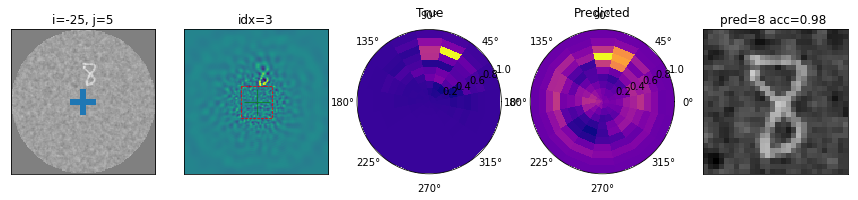

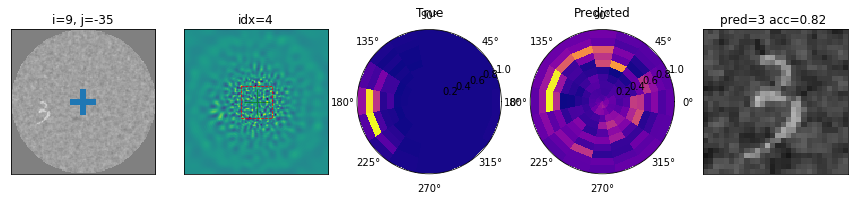

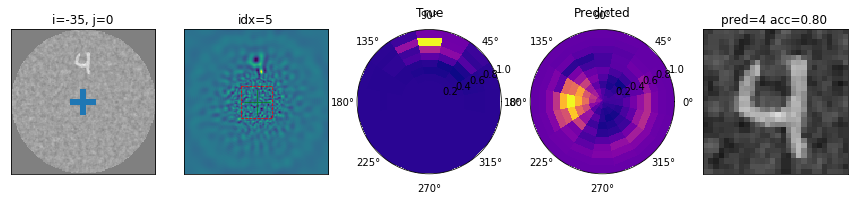

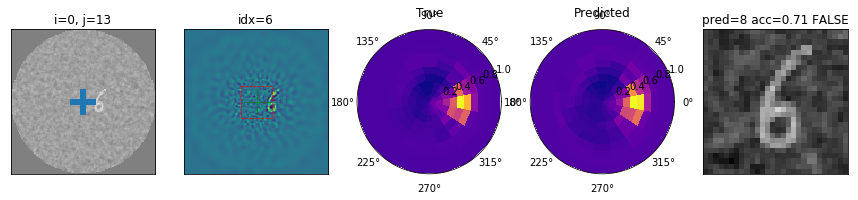

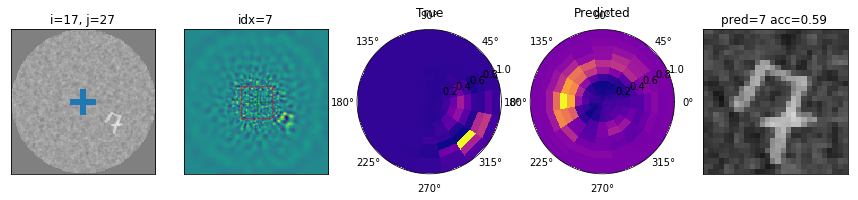

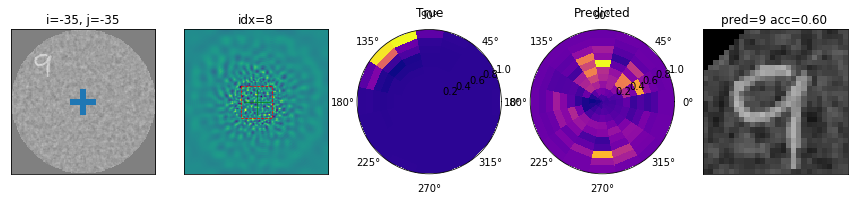

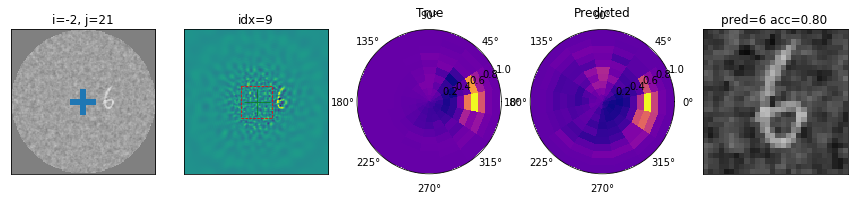

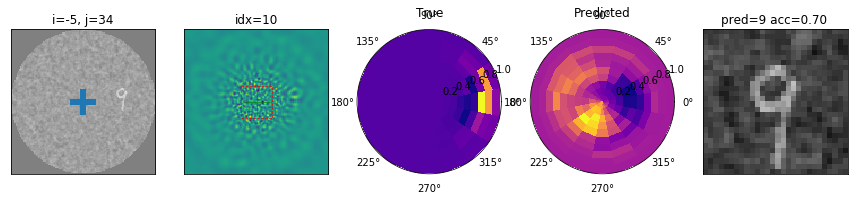

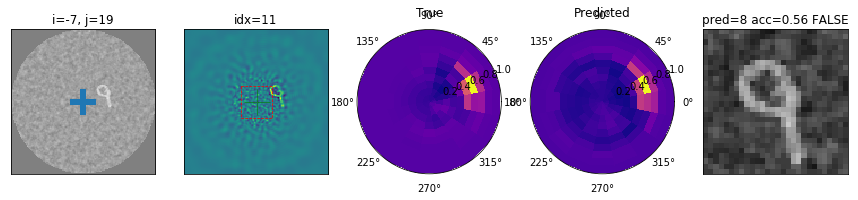

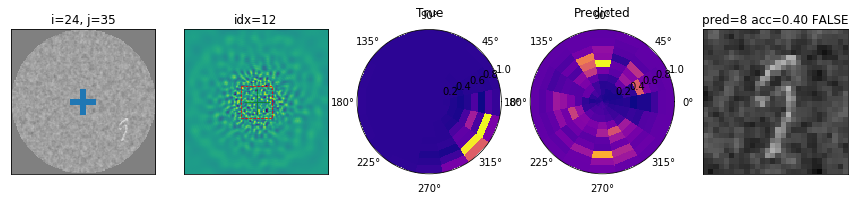

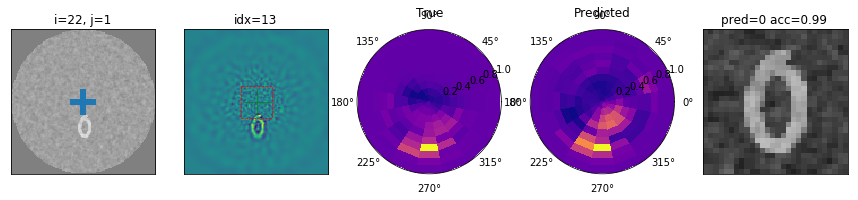

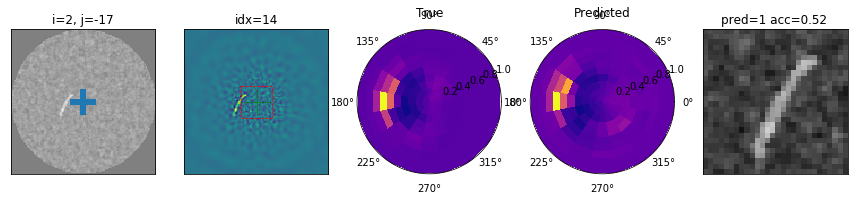

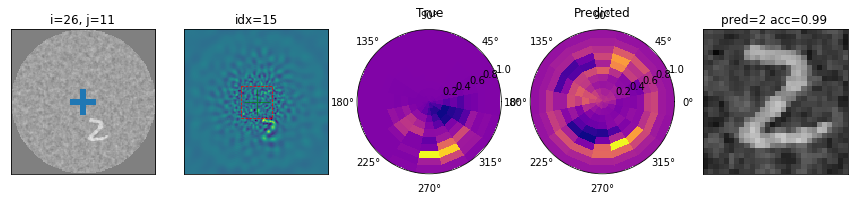

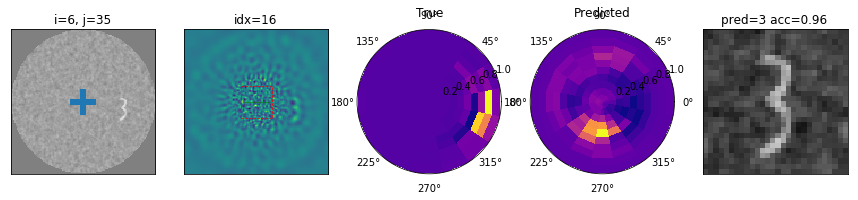

In [46]:
#for idx in range(args.test_batch_size): #range(3, 7):
for idx in range(3, 17):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    #ax = r.show(ax, r.retina_invert(retina_data[idx, :].numpy()))
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    ax.pcolor(r.theta, r.log_r, accuracy_colliculus[idx, :].numpy().reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("True")

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(r.theta, r.log_r, out_sig[idx, :].reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    ax.set_title("Predicted")

    ax = fig.add_subplot(155)
    ax = d.show(ax, im[idx, :, :], do_cross=False)
    result = '' if pred[idx]==label[idx].numpy() else 'FALSE'
    ax.set_title(f"pred={pred[idx]} acc={proba[idx,pred[idx]]:.2f} {result}")
                 

## NOT knowing the target

In [53]:
out_sig = F.sigmoid(out_t).detach().numpy()
proba = out_sig.reshape((args.test_batch_size, args.N_azimuth, args.N_eccentricity))

In [54]:
r.theta.shape, r.log_r.shape, proba.shape

((17, 11), (17, 11), (1000, 16, 10))

In [55]:
r.theta[:, 0], r.log_r[0, :]

(array([-1.76714587, -1.37444679, -0.9817477 , -0.58904862, -0.19634954,
         0.19634954,  0.58904862,  0.9817477 ,  1.37444679,  1.76714587,
         2.15984495,  2.55254403,  2.94524311,  3.33794219,  3.73064128,
         4.12334036,  4.51603944]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [56]:
r.theta_mid = .5 * (r.theta[:-1, 1:]+r.theta[1:, 1:])
r.log_r_mid = .5 * (r.log_r[1:, :-1]+r.log_r[1:, 1:])

In [57]:
r.theta_mid.shape, r.log_r_mid.shape, proba.shape

((16, 10), (16, 10), (1000, 16, 10))

In [59]:
proba.sum(axis=(1, 2)).shape

(1000,)

In [60]:
(r.log_r_mid[None, :, :]*proba).sum(axis=(1, 2)).shape

(1000,)

In [61]:
(r.log_r_mid[None, :, :]*proba).sum(axis=(1, 2))/proba.sum(axis=(1, 2))

array([0.52548627, 0.30173227, 0.42053592, 0.50092707, 0.53029993,
       0.50551781, 0.52926651, 0.54161606, 0.5315861 , 0.52630579,
       0.49063226, 0.54051438, 0.55216709, 0.50725773, 0.51957376,
       0.50119514, 0.49314861, 0.52024978, 0.49429763, 0.5348661 ,
       0.49649226, 0.47032581, 0.40203216, 0.46943064, 0.54177743,
       0.49821463, 0.50124927, 0.51279628, 0.4418782 , 0.48238288,
       0.47060931, 0.49186046, 0.41605409, 0.49910644, 0.50445731,
       0.50151689, 0.48609379, 0.57262419, 0.42335013, 0.37662525,
       0.5178152 , 0.49096039, 0.50398822, 0.50238888, 0.49815276,
       0.41155945, 0.49356269, 0.51906368, 0.52307128, 0.47649109,
       0.42998629, 0.49751556, 0.48388018, 0.50674777, 0.47354754,
       0.40136817, 0.4382021 , 0.51330362, 0.55037014, 0.53446769,
       0.51215191, 0.51255403, 0.49780083, 0.5250306 , 0.49532819,
       0.53854683, 0.53385886, 0.49577274, 0.52750846, 0.50436263,
       0.54737531, 0.45930829, 0.43567547, 0.53314172, 0.50344

In [ ]:
#col = colliculus_inverse @ a_data_n[idx,0,:]
#vec_t = Variable(torch.FloatTensor(accuracy_colliculus[idx, :].numpy()))
#vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))

#out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
#acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
#view = r.colliculus_inverse @ out_sig.flatten()

In [22]:
prediction.shape

torch.Size([1000, 160])

In [ ]:
from torch.autograd import Variable
import torch.nn.functional as F


#for idx in range(args.test_batch_size): #range(3, 7):
for idx in range(3, 7):
    fig = plt.figure(figsize = (15, 8))
    
    ax = fig.add_subplot(151)
    ax = d.show(ax, full[idx]['data_fullfield'])
    ax.set_title(f"i={full[idx]['i_offset']}, j={full[idx]['j_offset']}")
    
    ax = fig.add_subplot(152)
    #ax = r.show(ax, r.retina_invert(retina_data[idx, :].numpy()))
    data_retina = r.retina(full[idx]['data_fullfield'])
    ax = r.show(ax, r.retina_invert(data_retina))
    ax.set_title(f"idx={idx}")
              
    ax = fig.add_subplot(153, projection='polar')
    #col = colliculus_inverse @ a_data_n[idx,0,:]
    vec_t = Variable(torch.FloatTensor(accuracy_colliculus[idx, :].numpy()))
    vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    ax.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())
    out_t = where.model(retina_data[idx, :])
    out_sig = F.sigmoid(out_t).detach().numpy()
    out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
    #acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))
    view = r.colliculus_inverse @ out_sig.flatten()

    ax = fig.add_subplot(154, projection='polar')
    ax.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)), cmap=plt.plasma())

    ax = fig.add_subplot(155)
    im = where.extract(full[idx]['data_fullfield'], full[idx]['i_offset'], full[idx]['j_offset'])
    ax.imshow(im, cmap=plt.gray())

    proba = where.classify_what(im)
    pred = proba.argmax() # get the index of the max log-probability
    acc = proba[0, pred]
    result = '' if pred==label[idx] else 'FALSE'
    ax.set_title(f"pred={pred} acc={acc:.2f} {result}")
                 

In [ ]:
def test_eccentricities(N_eccentricities=9):
    vsize = args.N_theta*args.N_azimuth*args.N_eccentricity*args.N_phase
    asize = args.N_azimuth*args.N_eccentricity
    
    N_pic_mnist = 28
    N_class_mnist = 10

    test_batch_size = 1000
    
    mem_acc_log = []
    mem_acc_data_log = []
    mem_ref_log = [] 
    mem_ref_data_log = []

    ecc_max=.8
    r_pix = []

    eccentricities = range(N_eccentricities)
    for i_eccentricity in eccentricities:

        eccentricity = ecc_max * (1/args.rho)**(args.N_eccentricity - i_eccentricity)

        radius = args.N_pic / 2 * eccentricity
        print('at scale ', i_eccentricity, ' radius=', radius)
        r_pix.append(radius)

        data, label = next(iter(d.loader_test))

        input_n = np.zeros((args.test_batch_size, 1, vsize))
        a_data = np.zeros((args.test_batch_size, asize))
        full_fixmap_n = np.zeros((args.test_batch_size, args.N_pic**2))

        ref_data = np.zeros(test_batch_size)

        for idx in range(test_batch_size):
            theta = np.random.rand() * 2 * np.pi
            i_offset = int(radius * np.cos(theta))
            j_offset = int(radius * np.sin(theta))

            # changed
            data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), i_offset, j_offset)
            input_n[idx, 0, :]  =  r.retina(data_fullfield)

            a_data[idx, :], accuracy_fullfield_map = r.accuracy_fullfield(accuracy_map, i_offset, j_offset)
            full_fixmap_n[idx, :] = accuracy_fullfield_map.flatten()

            # when we do not do a saccade, the reference accurracy data is pre-computed 
            if radius <= N_pic_mnist:
                ref_data[idx] = accuracy_map[N_pic_mnist - 1 + i_offset, N_pic_mnist - 1 + j_offset]
            else:
                ref_data[idx] = 1 / N_class_mnist      


        in_t = Variable(torch.FloatTensor(input_n))
        out_t = net(in_t)
        a_data_t = Variable(torch.FloatTensor(a_data))
        acc, acc_data = accuracy_gain(out_t, a_data_t, test_batch_size, full_fixmap=full_fixmap_n)
        mem_acc_log += [acc]
        mem_acc_data_log += [acc_data]

        mem_ref_log += [np.mean(ref_data)]
    return r_pix, mem_acc_log, mem_ref_log

N_eccentricities = 9
r_pix, mem_acc_log, mem_ref_log = test_eccentricities(N_eccentricities)

In [ ]:
idx = 30
w = 28
in_t = Variable(torch.FloatTensor(input_n[idx,0,:]))
out_t = net(in_t)
out_sig = F.sigmoid(out_t).detach().numpy()

test = out_sig.reshape((args.N_azimuth, args.N_eccentricity))
indices_ij = np.where(test == max(test.flatten()))
azimuth = indices_ij[0][0]
eccentricity = indices_ij[1][0]
full_masque = r.colliculus[azimuth,eccentricity,:]
indice_move = np.where(full_masque == max(full_masque))
i_move = indice_move[0][0] // 128 - 64
j_move = indice_move[0][0] % 128 - 64
print(i_move, j_move)


fig = plt.figure(figsize = (figwidth, figwidth/2.5))#1.618))
ax_A = plt.subplot(1, 4, 1) 
ax_A = r.show(ax_A, r.retina_invert(input_n[idx, 0, :]))

ax_B = plt.subplot(2, 4, 2, projection='polar', autoscale_on=False)
vec_t = Variable(torch.FloatTensor(a_data_n[idx, 0, :]))
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
ax_B.pcolor(r.theta, r.log_r, vec_t.reshape((args.N_azimuth, args.N_eccentricity)))
ax_B.grid('off')
#ax.set_rgrids('off')
plt.title('True', fontsize = 14)
ax_B.set_yticklabels([])
ax_B.set_xticklabels([])

ax_Bb = plt.subplot(2, 4, 6, projection='polar')
ax_Bb.pcolor(r.theta, r.log_r, out_sig.reshape((args.N_azimuth, args.N_eccentricity)))
ax_Bb.set_title('Predicted', fontsize = 14)
ax_Bb.set_yticklabels([])
ax_Bb.set_xticklabels([])


ax_C = plt.subplot(1, 4, 3)
data_fullfield = d.place_object(data[idx, 0, :, :].numpy(), 0, 0)
input_vector  =  r.retina(data_fullfield)
ax_C = r.show(ax_C, r.retina_invert(input_vector))
ax_A.arrow(64.5, 64.5, j_move, i_move, width=.3, color='r', head_width=4., length_includes_head=True, edgecolor='k')
vec_t = vec_t.reshape((1, args.N_azimuth * args.N_eccentricity))
out_t = out_t.reshape((1, args.N_azimuth * args.N_eccentricity))
acc, _ = accuracy_gain(out_t, vec_t, 1, full_fixmap = full_fixmap_n[idx, :].reshape((1, -1)))

ax_D = plt.subplot(1, 4, 4)
r_ref = r_pix
r_ref = range(9)

ax_D.bar(r_ref, mem_acc_log, alpha = .5, label = 'One saccade')
ax_D.bar(r_ref, mem_ref_log, alpha = .5, label = 'No saccade') #accuracy_map[27,27:55])
ax_D.plot(np.arange(10)-.5, [0.1]*10, ':', c='k', label = 'Baseline')
plt.legend(loc='best')
ax_D.set_title('Class accuracy', fontsize = 14)
ax_D.set_xlabel('Target eccentricity (pixels)', fontsize = 12)
ax_D.set_xticks(range(9))
ax_D.set_xticklabels(['%.1f' % d for  d in r_pix])
ax_D.set_ylim([0,1])

for ax, text in [[ax_A, 'DIS'], [ax_C, 'SAC']]:
    ax.text(4, 15, text, fontsize=24,
          bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
          ha='left', va='center') 

offset = -.015
for ax, text, x_offset, y_offset in [[ax_A, 'A', offset, 1.15], [ax_B, 'B', -.25, 1.225], [ax_C, 'C', offset, 1.15], [ax_D, 'D', offset, 1.15]]:
    ax.text(x_offset, y_offset, '(' + text + ')', fontsize=24,
              bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
              ha='left', va='center', transform=ax.transAxes) 

# pos : [left, bottom, width, height] =    The new position of the in `.Figure` coordinates.    
plt.tight_layout()
ax_A.set_position([0.025, 0.1, .3, .45])
ax_B.set_position( [0.24, 0.375, .2, 0.2])
ax_Bb.set_position([0.24, 0.1, .2, 0.2])
ax_C.set_position([0.35, .1, .3, .45])
ax_D.set_position([0.65, .1, .3, .45])
fig.savefig(figname + '.pdf', bbox_inches='tight', pad_inches=0.1)

# post-processing

In [ ]:
!convert  -density {dpi_export} {figname}.pdf {figname}.jpg
!convert  -density {dpi_export} {figname}.pdf {figname}.png
#!convert  -density {dpi_export} -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 {fname}.pdf {fname}.tiff

In [ ]:
from IPython.display import Image
Image('{figname}.png'.format(figname=figname))

In [ ]:
!ls  -l {figname}*

## Version used

In [ ]:
%load_ext version_information
%version_information numpy, shl_scripts